In [1]:
from transformers import AutoTokenizer
from transformers import T5ForConditionalGeneration

model = "t5-small"
t5: T5ForConditionalGeneration = T5ForConditionalGeneration.from_pretrained(
        model
    )

tokenizer =  AutoTokenizer.from_pretrained(model)

In [2]:
from transformers import T5ForConditionalGeneration
from transformers.models.t5.modeling_t5 import T5Attention, T5Config, T5Block
from copy import deepcopy
from typing import List
from collections import defaultdict
t5: T5ForConditionalGeneration = T5ForConditionalGeneration.from_pretrained(
        "t5-small"
    )

def get_tf_attention_dict(module,kv_heads:int=4):
    transfer_to_gqa: List[str] = ["encoder","decoder","EncDecAttention"]
    tf_attention_dict = defaultdict(list)
    def convert_t5_to_gqa(module, kv_heads: int,similarity_flag:bool=False,inplace: bool = False,curr_name:str=''):
        """Get the list of attention modules based on the flag about encoder, decoder or cross-attention

        Args:
            module: Transformer module/unit
            kv_heads (int): Number of key-value heads
            similarity_flag (bool, optional): Similarity GQA flag. Defaults to False.
            inplace (bool, optional): inplace replace the model with GQA. Defaults to False.

        Returns:
            _type_: _description_
        """
        if isinstance(module, T5Attention) and similarity_flag:
            tf_attention_dict[curr_name].append(module)

        out = module if inplace else deepcopy(module)
        for name, child in out.named_children():
            if name in transfer_to_gqa:
                curr_name = name
                similarity_flag = True
            out._modules[name] = convert_t5_to_gqa(child, kv_heads=kv_heads,similarity_flag=similarity_flag, inplace=True,curr_name=curr_name)
        return out

    convert_t5_to_gqa(module,kv_heads=kv_heads)
    return tf_attention_dict

In [3]:
tf_attention_dict = get_tf_attention_dict(t5)

In [4]:
print(len(tf_attention_dict['encoder']))
print(len(tf_attention_dict['decoder']))
print(len(tf_attention_dict['EncDecAttention']))

6
6
6


In [43]:
import torch
import torch.nn.functional as F

def get_sim_score(query_heads_attn):
    query_heads = torch.tensor_split(query_heads_attn,8,dim=1)
    sim_keys = ['kv_heads_'+str(i) for i in range(0,len(query_heads)//2)]
    sim_keys_dict = {key: 0.0 for key in sim_keys}
    for i in range(0,len(query_heads)-1,2):
        vec1 = query_heads[i]
        vec2 = query_heads[i+1]
        # Flatten the vectors
        vec1_flat = vec1.reshape(-1).unsqueeze(0)
        vec2_flat = vec2.reshape(-1).unsqueeze(0)
        # print(vec1_flat.shape)

        # Calculate cosine similarity using PyTorch's F.cosine_similarity
        cosine_sim = F.cosine_similarity(vec1_flat, vec2_flat).item()
        if i==0: dict_name='0'
        elif i==2: dict_name='1'
        elif i==4:dict_name='2'
        elif i==6:dict_name='3'

        sim_keys_dict[f'kv_heads_{dict_name}']=[cosine_sim]
    return sim_keys_dict  

In [44]:
gqa_list = ['encoder','decoder','EncDecAttention']
all_similarities_dict = defaultdict(list)

for attn_name in gqa_list:
    #attn_name is encoder, decoder or cross-attention
    for attn_layer in tf_attention_dict[attn_name]:
        all_similarities_dict[attn_name].append(get_sim_score(attn_layer.q.weight.data))

In [45]:
len(all_similarities_dict['EncDecAttention'])

6

In [46]:
temp_similarities_dict = all_similarities_dict

In [48]:
for attn_name,curr_attn_dict in all_similarities_dict.items():

    for idx,attn_layer in enumerate(curr_attn_dict):
        for attn_heads,sim_scores in attn_layer.items():
            curr_val = temp_similarities_dict[attn_name][idx][attn_heads]
            all_similarities_dict[attn_name][idx][attn_heads].extend(curr_val)

In [59]:
len(all_similarities_dict['encoder'])

6

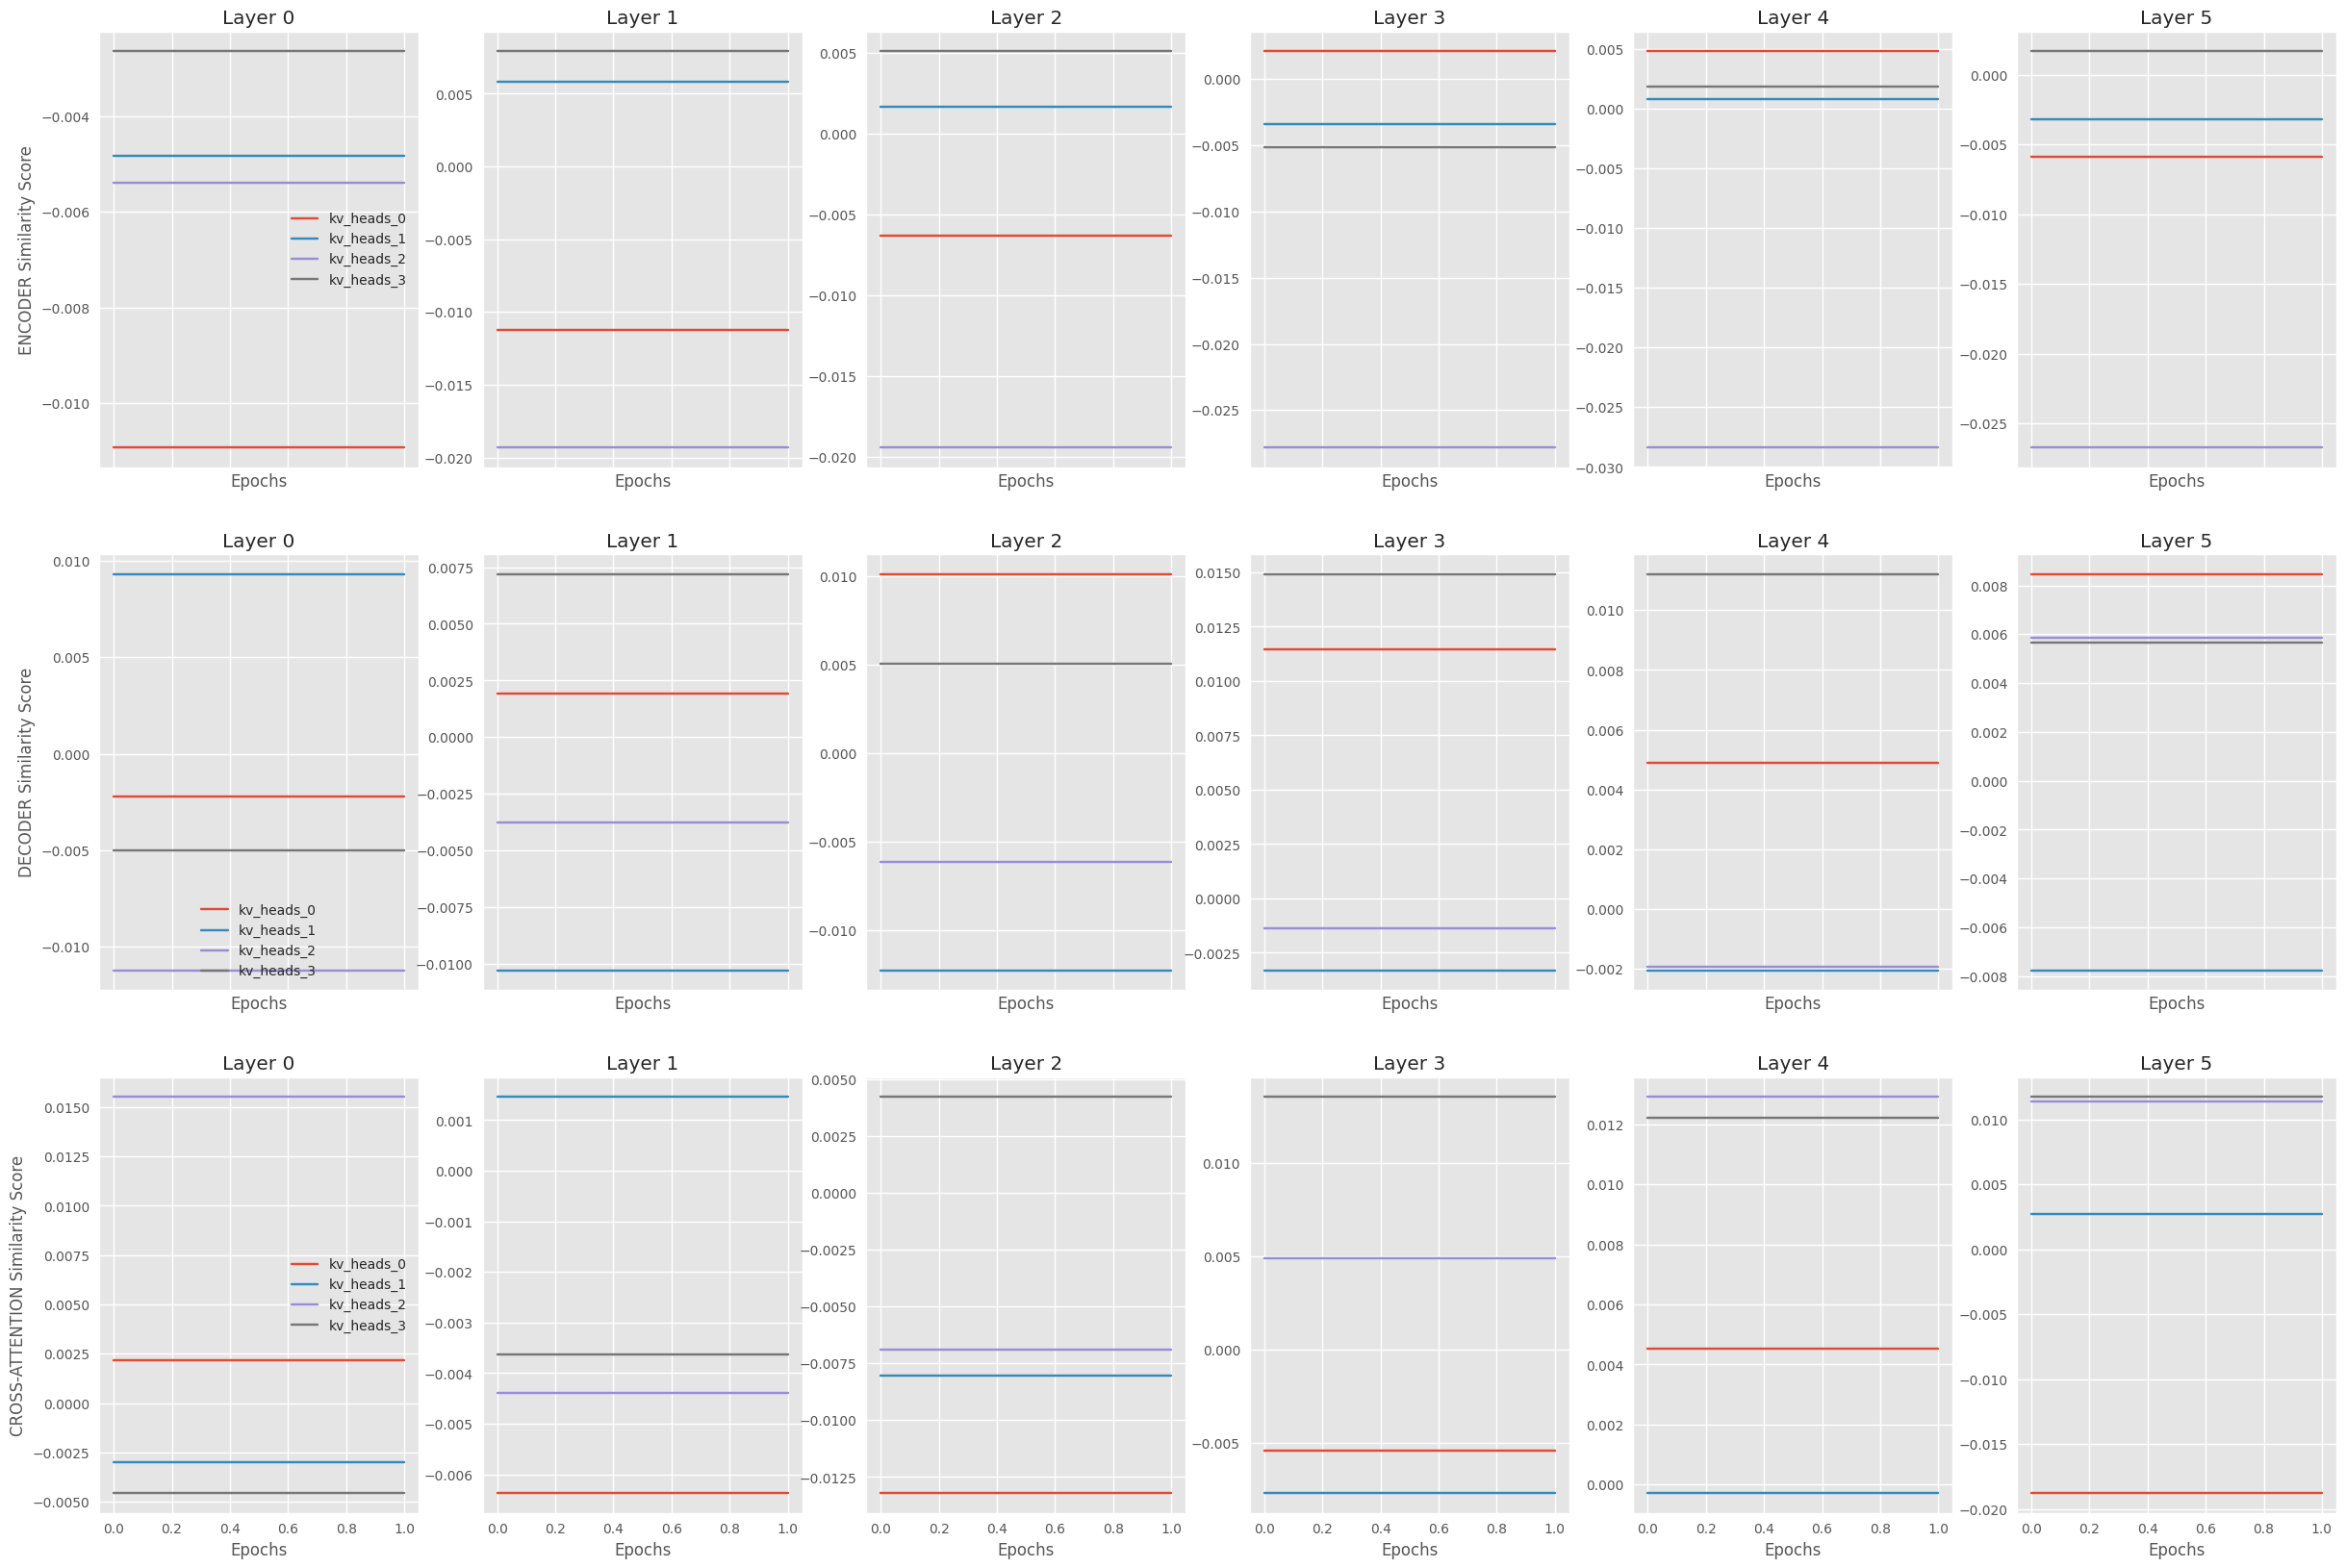

In [167]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
num_cols = len(all_similarities_dict[gqa_list[0]])
key_vals = all_similarities_dict.keys()
fig, ax = plt.subplots(3, 6, sharex=True,figsize=(30, 20))

fax = ax.ravel()
for i in range(6):
    for j in range(4):
        fax[i].plot(all_similarities_dict['encoder'][i][f'kv_heads_{j}'],label=f'kv_heads_{j}')
    fax[i].set_xlabel("Epochs")
    fax[i].set_title(f'Layer {i}')
fax[0].set_ylabel("ENCODER Similarity Score")
fax[0].legend()
    
for i in range(6,12):
    for j in range(4):
        fax[i].plot(all_similarities_dict['decoder'][i-6][f'kv_heads_{j}'],label=f'kv_heads_{j}')
    fax[i].set_xlabel("Epochs")
    fax[i].set_title(f'Layer {i-6}')
fax[6].set_ylabel("DECODER Similarity Score")
fax[6].legend()

for i in range(12,18):
    for j in range(4):
        fax[i].plot(all_similarities_dict['EncDecAttention'][i-12][f'kv_heads_{j}'],label=f'kv_heads_{j}')
    fax[i].set_xlabel("Epochs")
    fax[i].set_title(f'Layer {i-12}')
fax[12].set_ylabel("CROSS-ATTENTION Similarity Score")
fax[12].legend()

In [128]:
def tokenize_function_X(data):
    return tokenizer(data["article"],truncation=True,max_length=512)
def tokenize_function_Y(data):
    return tokenizer(data["highlights"],truncation=True,max_length=512)

In [174]:
from datasets import load_dataset

data_dir = "data"
tokenizer =  AutoTokenizer.from_pretrained(model,truncation=True,max_length=512,padding=True)
cnn_data_train = load_dataset("cnn_dailymail",data_dir=data_dir,split="train[:5%]")
cnn_data_test = load_dataset("cnn_dailymail",data_dir=data_dir,split="test[:100%]")
cnn_data_val = load_dataset("cnn_dailymail",data_dir=data_dir,split="validation[:100%]")

In [175]:
batch_size = 1000
X_train = cnn_data_train.map(tokenize_function_X,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])
y_train = cnn_data_train.map(tokenize_function_Y,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])

X_val = cnn_data_val.map(tokenize_function_X,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])
y_val = cnn_data_val.map(tokenize_function_Y,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])

X_test = cnn_data_test.map(tokenize_function_X,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])
y_test = cnn_data_test.map(tokenize_function_Y,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])

Map:   0%|          | 0/14356 [00:00<?, ? examples/s]

Map:   0%|          | 0/14356 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [132]:
X_train.column_names

['input_ids', 'attention_mask']

In [208]:
class CNNDataset(torch.utils.data.Dataset):
    def __init__(self, article_encodings, highlights_encodings):
        self.article_encodings = article_encodings
        self.highlights_encodings = highlights_encodings

    def __getitem__(self, idx):
        # item = {key: torch.tensor(self.article_encodings[key][idx]) for key in ['input_ids','attention_mask']}
        item = {}
        item['article'] = {key: torch.tensor(val) for key, val in self.article_encodings[idx].items()}
        item['highlights'] = {key: torch.tensor(val) for key, val in self.highlights_encodings[idx].items()}
        return item

    def __len__(self):
        return len(self.highlights_encodings)

In [209]:
tokenizer =  AutoTokenizer.from_pretrained(model,truncation=True,max_length=512,padding=True)

In [210]:
len(y_val)

13368

In [211]:
# trainDataset = CNNDataset(X_train.to_dict(),y_train.to_dict())
# testDataset = CNNDataset(X_test.to_dict(),y_test.to_dict())
valDataset = CNNDataset(X_val,y_val)

In [212]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
collate_fn=data_collator
# train_dataloader = DataLoader(
#     trainDataset, shuffle=True, batch_size=4
# )
eval_dataloader = DataLoader(
    valDataset,batch_size=4, collate_fn=data_collator
)
# test_dataloader = DataLoader(
#     testDataset,batch_size=4
# )

In [213]:
for batch in eval_dataloader:
    break

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided ['article', 'highlights']

In [195]:
batch

NameError: name 'batch' is not defined

In [27]:
for val_batch in eval_dataloader:
    break

In [34]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([8, 2098]), 'attention_mask': torch.Size([8, 2098])}

In [51]:
from transformers import AdamW
from transformers import get_scheduler
import torch
optimizer = torch.optim.AdamW(t5.parameters(), lr=5e-5)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)


71779


In [52]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
t5.to(device)
device

device(type='cuda')

In [53]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

t5.train()
for epoch in range(num_epochs):
    for batch_x,batch_y in zip(train_dataloader,eval_dataloader):
        # batch_x = {k: v.to(device) for k, v in batch_x.items()}
        # batch_y = {k: v.to(device) for k, v in batch_y.items()}

        outputs = t5(input_ids=batch_x.input_ids.to(device),labels=batch_y.input_ids.to(device))
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/71779 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
print(outputs.loss)

tensor(10.7395, grad_fn=<NllLossBackward0>)


In [ ]:
print(outputs.logits.shape)

torch.Size([32, 71, 32128])


In [16]:
text = """
In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow directions, according to Leifman. So, they end up on the ninth floor severely mentally disturbed, but not getting any real help because they're in jail. We toured the jail with Leifman. He is well known in Miami as an advocate for justice and the mentally ill. Even though we were not exactly welcomed with open arms by the guards, we were given permission to shoot videotape and tour the floor. Go inside the 'forgotten floor' » . At first, it's hard to determine where the people are. The prisoners are wearing sleeveless robes. Imagine cutting holes for arms and feet in a heavy wool sleeping bag -- that's kind of what they look like. They're designed to keep the mentally ill patients from injuring themselves. That's also why they have no shoes, laces or mattresses. Leifman says about one-third of all people in Miami-Dade county jails are mentally ill. So, he says, the sheer volume is overwhelming the system, and the result is what we see on the ninth floor. Of course, it is a jail, so it's not supposed to be warm and comforting, but the lights glare, the cells are tiny and it's loud. We see two, sometimes three men -- sometimes in the robes, sometimes naked, lying or sitting in their cells. "I am the son of the president. You need to get me out of here!" one man shouts at me. He is absolutely serious, convinced that help is on the way -- if only he could reach the White House. Leifman tells me that these prisoner-patients will often circulate through the system, occasionally stabilizing in a mental hospital, only to return to jail to face their charges. It's brutally unjust, in his mind, and he has become a strong advocate for changing things in Miami. Over a meal later, we talk about how things got this way for mental patients. Leifman says 200 years ago people were considered "lunatics" and they were locked up in jails even if they had no charges against them. They were just considered unfit to be in society. Over the years, he says, there was some public outcry, and the mentally ill were moved out of jails and into hospitals. But Leifman says many of these mental hospitals were so horrible they were shut down. Where did the patients go? Nowhere. The streets. They became, in many cases, the homeless, he says. They never got treatment. Leifman says in 1955 there were more than half a million people in state mental hospitals, and today that number has been reduced 90 percent, and 40,000 to 50,000 people are in mental hospitals. The judge says he's working to change this. Starting in 2008, many inmates who would otherwise have been brought to the "forgotten floor" will instead be sent to a new mental health facility -- the first step on a journey toward long-term treatment, not just punishment. Leifman says it's not the complete answer, but it's a start. Leifman says the best part is that it's a win-win solution. The patients win, the families are relieved, and the state saves money by simply not cycling these prisoners through again and again. And, for Leifman, justice is served. E-mail to a friend ."""

In [23]:
input_ids = tokenizer(
    f"summarize: {text}", return_tensors="pt"
).input_ids  # Batch size 1
outputs = t5.generate(input_ids,max_new_tokens=500,num_beams=5,top_p=0.8,do_sample=True)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

judge says one-third of all people in Miami-dade jails are mentally ill. mentally ill inmates housed on "forgotten floor" until ready to appear in court. judge says many mentally ill inmates will be sent to a new mental health facility. "it's not the complete answer, but it's a start," judge says.


In [12]:
input_ids.shape

torch.Size([1, 629])